Link to all the saved models from this notebook:
https://drive.google.com/drive/folders/1aY-2dLsjI1dzYEKRLoakiRsYuOn2R1h7?usp=sharing 

Link to model comparision Excel:
https://docs.google.com/spreadsheets/d/1PQMkZO4YFyAtku2J2M1kXJvyEUlSIkDWDXOgHLMnmAk/edit?usp=sharing 

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import joblib
from collections import defaultdict
import torch

# Sklearn imports
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, confusion_matrix, precision_recall_curve, matthews_corrcoef, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K
import torch

# XGBoost
from xgboost import XGBClassifier

#Tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

# Imbalanced Learning
from imblearn.over_sampling import SMOTENC

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
from warnings import filterwarnings
filterwarnings('ignore')

/Users/gunturuvarsha/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Failure Event

## loading data

In [8]:
df = pd.read_csv('military_asset_maintenance_data.csv')
df.head()

,Asset_ID,Asset_Type,Age_of_Asset,Usage_Hours,Temperature,Pressure,Fuel_Consumption,Vibration_Levels,Humidity,Location,Maintenance_History,Failure_Event
0,1,Ship,9,5740,44.968711,137.776053,49.336583,0.043240,59.341921,Temperate,2,0
1,2,Aircraft,16,8326,74.398522,37.204956,95.947730,0.171963,27.762498,Tropical,2,0
2,3,Ship,11,2667,58.640931,146.077726,72.209295,0.285799,48.473243,Desert,1,0
3,4,Ship,14,8436,73.961007,141.785229,33.231257,0.540367,25.760009,Temperate,1,0
4,5,Aircraft,8,6835,45.759227,56.240621,38.631240,0.204255,60.852518,Tropical,2,0


### Mapping categorical variables

In [3]:
# mapping columns
categorical_cols = ['Asset_Type', 'Location']

# Dictionary to store mappings
category_mappings = {}

for col in categorical_cols:
    unique_values = df[col].unique()
    mapping = {val: idx for idx, val in enumerate(unique_values)}
    df[col] = df[col].map(mapping)
    category_mappings[col] = mapping


for col, mapping in category_mappings.items():
    print(f"{col} mapping: {mapping}")

Asset_Type mapping: {'Ship': 0, 'Aircraft': 1, 'Vehicle': 2}
Location mapping: {'Temperate': 0, 'Tropical': 1, 'Desert': 2}


### Feature Engineering for to capture complex relationships in data

In [4]:
df['Thermal_Stress'] = df['Usage_Hours'] * df['Temperature']
df['Age_Vibration_Interaction'] = df['Age_of_Asset'] * df['Vibration_Levels']
df['Fuel_Efficiency'] = df['Fuel_Consumption'] / (df['Usage_Hours'] + 1e-5)  # avoid division by 0
df['Pressure_Temp_Interaction'] = df['Pressure'] * df['Temperature']
df['Operational_Stress_Index'] = (df['Vibration_Levels'] + df['Pressure'] +  df['Temperature'] +  df['Usage_Hours'])/ (df['Age_of_Asset'] + 1e-5)
df.drop(columns=['Asset_ID'], inplace=True)
df.head()


,Asset_Type,Age_of_Asset,Usage_Hours,Temperature,Pressure,Fuel_Consumption,Vibration_Levels,Humidity,Location,Maintenance_History,Failure_Event,Thermal_Stress,Age_Vibration_Interaction,Fuel_Efficiency,Pressure_Temp_Interaction,Operational_Stress_Index
0,0,9,5740,44.968711,137.776053,49.336583,0.043240,59.341921,0,2,0,258120.403835,0.389162,0.008595,6195.611574,658.086825
1,1,16,8326,74.398522,37.204956,95.947730,0.171963,27.762498,1,2,0,619442.090624,2.751404,0.011524,2767.993702,527.360635
2,0,11,2667,58.640931,146.077726,72.209295,0.285799,48.473243,2,1,0,156395.363951,3.143794,0.027075,8566.133914,261.091077
3,0,14,8436,73.961007,141.785229,33.231257,0.540367,25.760009,0,1,0,623935.057788,7.565140,0.003939,10486.578333,618.020030
4,1,8,6835,45.759227,56.240621,38.631240,0.204255,60.852518,1,2,0,312764.319305,1.634040,0.005652,2573.527343,867.149429


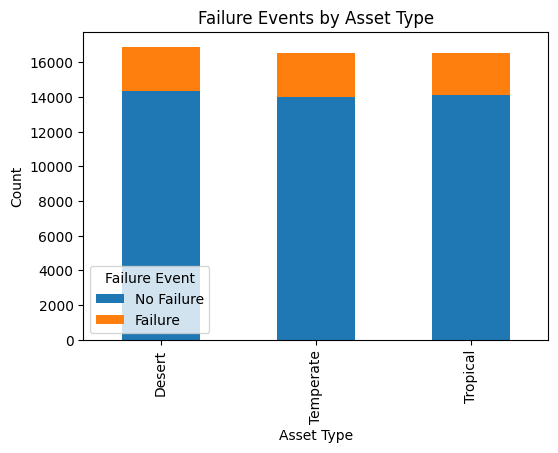

In [9]:
df[["Location", "Failure_Event"]].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title("Failure Events by Asset Type")
plt.xlabel("Asset Type")
plt.ylabel("Count")
plt.legend(title="Failure Event", labels=["No Failure", "Failure"])

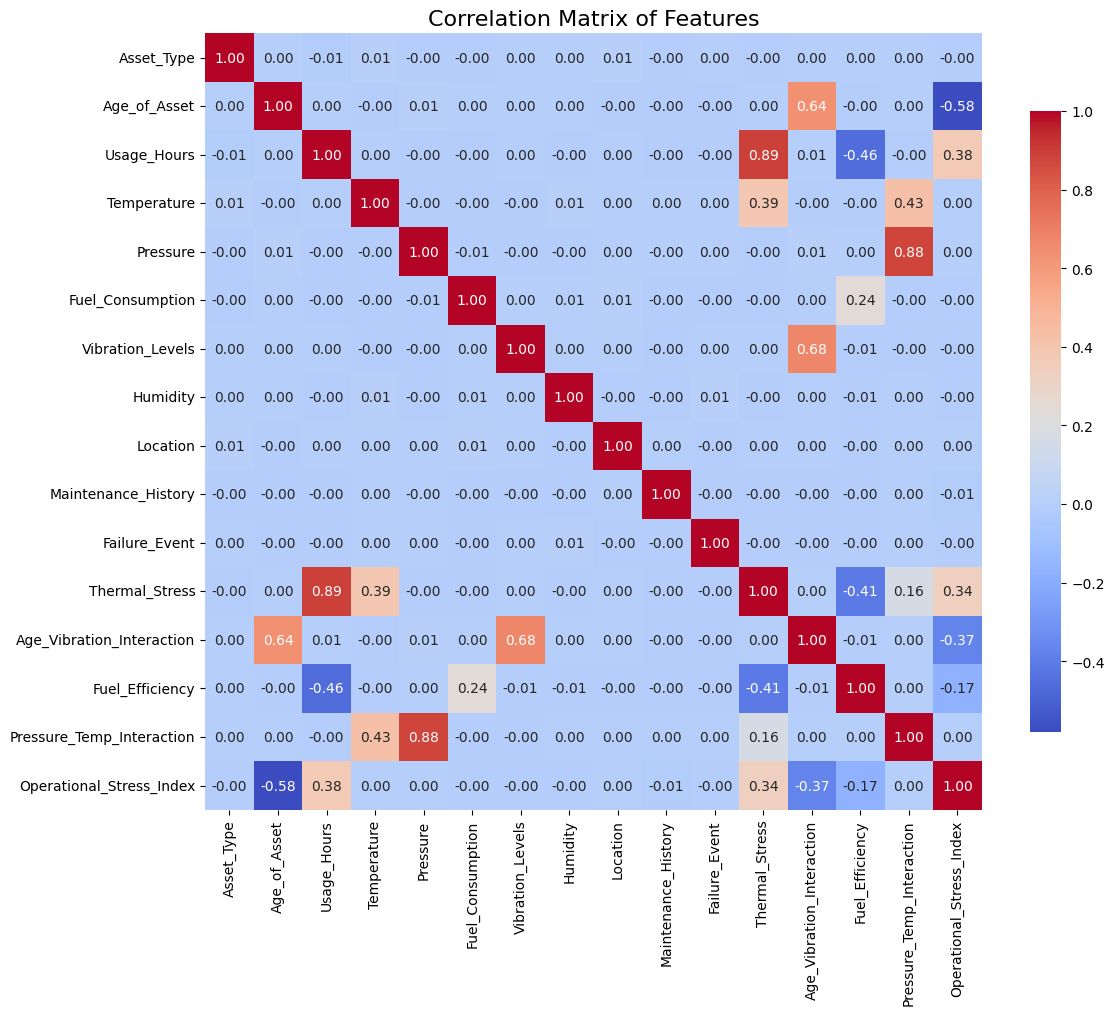

In [5]:
corr_matrix = df.corr()

# Set up the plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Features", fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from imblearn.over_sampling import SMOTENC
from collections import Counter

# Features and target
X = df.drop(columns=['Failure_Event'])
y = df['Failure_Event']

# Define categorical and numerical features
cat_features = ['Asset_Type', 'Location', 'Maintenance_History']
num_features = [col for col in X.columns if col not in cat_features]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Apply SMOTE to balance the classes in the training data ---
categorical_indices = [X_train.columns.get_loc(col) for col in cat_features]

print("Before SMOTE:", Counter(y_train))

# Apply SMOTENC (for categorical and continuous features)
smote_nc = SMOTENC(
    categorical_features=categorical_indices,
    sampling_strategy=0.5,  # Make minority class 50% the size of the majority class
    random_state=42
)

X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train, y_train)

# Convert back to DataFrame for further processing
X_train_final = pd.DataFrame(X_train_balanced, columns=X_train.columns)
y_train_final = pd.Series(y_train_balanced, name='Failure_Event')

print("After SMOTE:", Counter(y_train_balanced))

# --- Scale numeric features after SMOTE ---
scaler = StandardScaler()

# Separate numerical columns for scaling
X_train_num = X_train_final[num_features]
X_val_num = X_val[num_features]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled = scaler.transform(X_val_num)

# Convert back to DataFrame
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=num_features).reset_index(drop=True)
X_val_num_scaled_df = pd.DataFrame(X_val_num_scaled, columns=num_features).reset_index(drop=True)

# Prepare final training and validation sets by combining scaled numeric and encoded categorical features
X_train_final = pd.concat([X_train_num_scaled_df, X_train_final[cat_features].reset_index(drop=True)], axis=1)
X_val_final = pd.concat([X_val_num_scaled_df, X_val[cat_features].reset_index(drop=True)], axis=1)


Before SMOTE: Counter({0: 33949, 1: 6051})
After SMOTE: Counter({0: 33949, 1: 16974})


Upsampling the minority class more than 5x, which can have a significant impact on your model's performance and even lead to overfitting if not handled carefully. Therefore instead of fully balancing the classes, the minority class is being made 50% of majority class.

## ANN Code

In [18]:
CATEGORICAL_COLS = ['Asset_Type', 'Location', 'Maintenance_History']
TARGET_COL = 'Failure_Event'
RANDOM_STATE = 42
EPOCHS = 50
BATCH_SIZE = 64
FOLDS = 5  # Number of cross-validation folds

# Cross-validation setup
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Store AUC and classification report results
aucs = []
all_reports = []

# Early stopping configuration
early_stopping = EarlyStopping(
    monitor='val_loss',  # You can monitor 'val_accuracy' or 'val_auc' if needed
    patience=5,          # Number of epochs with no improvement after which training will stop
    restore_best_weights=True,  # Restore the model weights from the epoch with the best validation loss
    verbose=1            # To display the early stopping message
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # Metric to monitor
    factor=0.5,                # Factor to reduce the learning rate by
    patience=3,                # Number of epochs with no improvement to wait
    min_lr=1e-6,               # Lower bound on learning rate
    verbose=1
)

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_final, y_train_final)):  # Use resampled data
    print(f"\nTraining Fold {fold + 1}/{FOLDS}")
    
    X_train_ANN = X_train_final.iloc[train_idx]
    X_val_ANN = X_train_final.iloc[val_idx]
    
    y_train_ANN = y_train_final.iloc[train_idx]
    y_val_ANN = y_train_final.iloc[val_idx]
    
    # Build and compile the model
    model = Sequential([
        Dense(12, activation='relu', kernel_initializer='he_normal', input_shape=(X_train_ANN.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(12, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(10, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.1),

        Dense(1, kernel_initializer='glorot_normal', activation='sigmoid')  # Binary classification
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy','precision','recall','auc']
    )


    class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_ANN),
    y=y_train_ANN
    )
    #Convert to dictionary format required by Keras
    class_weights = dict(enumerate(class_weights_array))
    print("Class Weights:", class_weights)
    
    # Train the model
    model.fit(
        X_train_ANN, y_train_ANN,
        validation_data=(X_val_ANN, y_val_ANN),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights,
        verbose=1
    )

    # Evaluate the model
    y_pred = model.predict(X_val_ANN)
    auc = roc_auc_score(y_val_ANN, y_pred)
    y_pred_bin = (y_pred >= 0.5).astype(int)
    
    # Store results
    aucs.append(auc)
    all_reports.append(classification_report(y_val_ANN, y_pred_bin, digits=4))
    
    print(f"\nFold {fold + 1} - AUC: {auc:.4f}")
    print(classification_report(y_val_ANN, y_pred_bin, digits=4))
    mcc = matthews_corrcoef(y_val_ANN, y_pred_bin)
    print(f"MCC: {mcc:.4f}")

# Calculate average AUC score
avg_auc = np.mean(aucs)
print(f"\nAverage AUC across all folds: {avg_auc:.4f}")


Training Fold 1/5


2025-04-17 10:05:36.021013: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-17 10:05:36.021409: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-17 10:05:36.021418: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-17 10:05:36.021876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-17 10:05:36.021902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Class Weights: {0: 0.7499907949482676, 1: 1.5000368215627071}
Epoch 1/50


2025-04-17 10:05:36.937444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


637/637 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.5020 - auc: 0.4987 - loss: 0.7348 - precision: 0.3363 - recall: 0.5019 - val_accuracy: 0.5220 - val_auc: 0.5151 - val_loss: 0.6924 - val_precision: 0.3471 - val_recall: 0.4925 - learning_rate: 0.0010
Epoch 2/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.4997 - auc: 0.5029 - loss: 0.6985 - precision: 0.3350 - recall: 0.5050 - val_accuracy: 0.5189 - val_auc: 0.5056 - val_loss: 0.6922 - val_precision: 0.3354 - val_recall: 0.4515 - learning_rate: 0.0010
Epoch 3/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.4956 - auc: 0.4998 - loss: 0.6979 - precision: 0.3380 - recall: 0.5224 - val_accuracy: 0.5194 - val_auc: 0.5156 - val_loss: 0.6927 - val_precision: 0.3471 - val_recall: 0.5013 - learning_rate: 0.0010
Epoch 4/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.5199 - auc: 0.5108 - loss: 0.6931 - precision: 0.3382 - recall: 0.4752 - val_accuracy: 0.4890 - val_auc: 0.5224 - val_loss: 0.6947 - val_pr

## FNN with embedings

In [ ]:
# Settings
FOLDS = 5
RANDOM_STATE = 42
EPOCHS = 200
BATCH_SIZE = 64
cat_cols = ['Asset_Type', 'Location', 'Maintenance_History']
num_cols = [col for col in X_train_final.columns if col not in cat_cols]

# Initialize stratified k-fold
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
cv_metrics = defaultdict(list)

# Convert to numpy for indexing
X_all = X_train_final.copy().reset_index(drop=True)
y_all = y_train_final.reset_index(drop=True)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_all, y_all)):
    print(f"\n=== Fold {fold + 1}/{FOLDS} ===")

    # Split the data
    FNN_X_train, FNN_X_val = X_all.iloc[train_idx], X_all.iloc[val_idx]
    FNN_y_train, FNN_y_val = y_all.iloc[train_idx], y_all.iloc[val_idx]

    FNN_X_train_cat = FNN_X_train[cat_cols].reset_index(drop=True)
    FNN_X_val_cat = FNN_X_val[cat_cols].reset_index(drop=True)

    # Numeric features
    FNN_X_train_num = FNN_X_train[num_cols].values
    FNN_X_val_num = FNN_X_val[num_cols].values

    # Define inputs
    input_cats = [Input(shape=(1,), name=f"{col}") for col in cat_cols]
    input_num = Input(shape=(len(num_cols),), name="numeric")

    class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(FNN_y_train),
    y=FNN_y_train)
    #Convert to dictionary format required by Keras
    class_weights = dict(enumerate(class_weights_array))
    print("Class Weights:", class_weights)

    # Embeddings
    embeddings = []
    for i, col in enumerate(cat_cols):
        vocab_size = int(FNN_X_train_cat[col].nunique()) + 1
        emb_dim = min(50, vocab_size // 2)
        emb = Embedding(input_dim=vocab_size, output_dim=emb_dim, name=f"emb_{col}")(input_cats[i])
        embeddings.append(Flatten()(emb))

    # Model definition
    x = Concatenate()(embeddings + [input_num])
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_cats + [input_num], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]

    # Fit model
    model.fit(
        [FNN_X_train_cat[col].values for col in cat_cols] + [FNN_X_train_num],
        FNN_y_train,
        validation_data=([FNN_X_val_cat[col].values for col in cat_cols] + [FNN_X_val_num], FNN_y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        class_weight = class_weights,
        verbose=1
    )

    # Predict
    y_pred = model.predict([FNN_X_val_cat[col].values for col in cat_cols] + [FNN_X_val_num])
    y_pred_bin = (y_pred >= 0.5).astype(int)

    auc = roc_auc_score(FNN_y_val, y_pred)
    print(f"AUC: {auc:.4f}")
    print(classification_report(FNN_y_val, y_pred_bin, digits=4))
    mcc = matthews_corrcoef(FNN_y_val, y_pred_bin)
    print(f"MCC: {mcc:.4f}")

    cv_metrics['auc'].append(auc)

# Summary
print("\n=== Cross-Validation Summary ===")
for metric, scores in cv_metrics.items():
    print(f"{metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

torch.save(model, 'Failure_Event_fnn_model_with_embeddings.pth')



=== Fold 1/5 ===
Class Weights: {0: 0.7499907949482676, 1: 1.5000368215627071}
Epoch 1/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.5456 - auc_9: 0.5492 - loss: 0.6890 - val_accuracy: 0.5758 - val_auc_9: 0.6140 - val_loss: 0.6719
Epoch 2/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5558 - auc_9: 0.6026 - loss: 0.6783 - val_accuracy: 0.5710 - val_auc_9: 0.6401 - val_loss: 0.6710
Epoch 3/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5731 - auc_9: 0.6222 - loss: 0.6733 - val_accuracy: 0.6141 - val_auc_9: 0.6518 - val_loss: 0.6528
Epoch 4/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5776 - auc_9: 0.6305 - loss: 0.6673 - val_accuracy: 0.5913 - val_auc_9: 0.6439 - val_loss: 0.6623
Epoch 5/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5876 - auc_9: 0.6331 - loss: 0.6640 - val_accuracy: 0.5955 - val_auc_9: 0.6559 - val_loss: 0.6591
Epoch 6/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5890 - auc_9: 0.

In [ ]:
# this code has been run in Final_Code.ipynb but kept here for record

# Preprocess validation set
X_val_cat = X_val_final[cat_cols].reset_index(drop=True)
X_val_num = X_val_final[num_cols].values

# Predict on X_val_final
y_pred_val = FNN_M_model.predict([X_val_cat[col].values for col in cat_cols] + [X_val_num]).flatten()
y_pred_bin_val = (y_pred_val >= 0.5).astype(int)

# AUC
val_auc = roc_auc_score(y_val, y_pred_val)
print(f"Validation AUC: {val_auc:.4f}")

# Classification Report
print(classification_report(y_val, y_pred_bin_val, digits=4))

# MCC
val_mcc = matthews_corrcoef(y_val, y_pred_bin_val)
print(f"Validation MCC: {val_mcc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_bin_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## TAB NET

In [ ]:
# Configuration
TARGET_COL = 'Failure_Event'
CATEGORICAL_COLS = ['Asset_Type', 'Location', 'Maintenance_History']
RANDOM_STATE = 42
N_SPLITS = 5
EPOCHS = 200
BATCH_SIZE = 64

# Identify categorical feature indices and dimensions
cat_idxs = [X_train_balanced.columns.get_loc(col) for col in CATEGORICAL_COLS]
cat_dims = [int(df[col].nunique()) for col in CATEGORICAL_COLS]
cat_emb_dim = [min(50, (dim + 1) // 2) for dim in cat_dims]

# Cross-validation setup
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

fold = 1
auc_scores = []

classes = np.unique(y_train_balanced)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_balanced)
weights = dict(zip(classes, class_weights))

for train_idx, val_idx in skf.split(X_train_balanced, y_train_balanced):
    print(f"\n==== Fold {fold} ====")
    
    TAB_X_train, TAB_X_val = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[val_idx]
    TAB_y_train,TAB_y_val = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[val_idx]

    # Initialize and train the model
    clf = TabNetClassifier(
        n_d=32, n_a=32, n_steps=5, gamma=1.5,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=cat_emb_dim,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-2),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        seed=RANDOM_STATE,
        verbose=1
    )

    clf.fit(
        X_train=TAB_X_train.values, y_train=TAB_y_train.values,
        eval_set=[(TAB_X_val.values, TAB_y_val.values)],
        eval_name=['val'],
        eval_metric=['auc'],
        max_epochs=EPOCHS,
        patience=20,
        batch_size=BATCH_SIZE,
        virtual_batch_size=128,
        weights = weights
    )

    # Evaluation
    y_pred_proba = clf.predict_proba(TAB_X_val.values)[:, 1]
    y_pred = clf.predict(TAB_X_val.values)
    auc = roc_auc_score(TAB_y_val.values, y_pred_proba)
    print(classification_report(TAB_y_val.values, y_pred, digits=4))
    print(f"Fold {fold} AUC: {auc:.4f}")
    auc_scores.append(auc)
    mcc = matthews_corrcoef(TAB_y_val, y_pred)
    print(f"MCC: {mcc:.4f}")
    
    fold += 1

# Final average AUC
print(f"\n==== Cross-Validation Complete ====")
print(f"Mean AUC: {np.mean(auc_scores):.4f} | Std AUC: {np.std(auc_scores):.4f}")

clf.save_model("Failure_Event_tabnet_model")



==== Fold 1 ====
epoch 0  | loss: 0.71458 | val_auc: 0.58514 |  0:00:07s
epoch 1  | loss: 0.68575 | val_auc: 0.59763 |  0:00:15s
epoch 2  | loss: 0.68108 | val_auc: 0.61216 |  0:00:24s
epoch 3  | loss: 0.67893 | val_auc: 0.61338 |  0:00:32s
epoch 4  | loss: 0.67825 | val_auc: 0.61639 |  0:00:40s
epoch 5  | loss: 0.6744  | val_auc: 0.61304 |  0:00:48s
epoch 6  | loss: 0.67283 | val_auc: 0.6182  |  0:00:57s
epoch 7  | loss: 0.6697  | val_auc: 0.6287  |  0:01:06s
epoch 8  | loss: 0.67066 | val_auc: 0.63418 |  0:01:14s
epoch 9  | loss: 0.66839 | val_auc: 0.63039 |  0:01:23s
epoch 10 | loss: 0.67151 | val_auc: 0.62486 |  0:01:31s
epoch 11 | loss: 0.67072 | val_auc: 0.61996 |  0:01:39s
epoch 12 | loss: 0.67    | val_auc: 0.63585 |  0:01:48s
epoch 13 | loss: 0.66961 | val_auc: 0.62514 |  0:01:56s
epoch 14 | loss: 0.66823 | val_auc: 0.63112 |  0:02:03s
epoch 15 | loss: 0.66733 | val_auc: 0.63498 |  0:02:11s
epoch 16 | loss: 0.66758 | val_auc: 0.6419  |  0:02:18s
epoch 17 | loss: 0.66449 | val

'Failure_Event_tabnet_model.zip'

In [ ]:
# Predict probabilities and labels

# this code has been run in Final_Code.ipynb but kept here for record

# Predict
TAB_x = X_val.values
TAB_y = y_val

y_pred_proba = clf_M.predict_proba(TAB_x)[:, 1]
y_pred = clf_M.predict(TAB_x)

# AUC
auc_score = roc_auc_score(TAB_y, y_pred_proba)
print(f"\nFinal Validation AUC: {auc_score:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(TAB_y, y_pred, digits=4))

# MCC
mcc = matthews_corrcoef(TAB_y, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Confusion matrix
cm = confusion_matrix(TAB_y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(TAB_y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(TAB_y, y_pred_proba)
avg_precision = average_precision_score(TAB_y, y_pred_proba)


plt.figure(figsize=(8, 6))
plt.hist(y_pred_proba[TAB_y == 0], bins=30, alpha=0.6, label='Class 0 (No Failure)', color='skyblue')
plt.hist(y_pred_proba[TAB_y == 1], bins=30, alpha=0.6, label='Class 1 (Failure)', color='salmon')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Histogram of Predicted Probabilities by Class')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

import seaborn as sns

# Explain method to get global feature importance
explain_matrix, masks = clf_M.explain(TAB_x)  # TAB_x should be your validation features

# Create DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': explain_matrix.sum(axis=0)
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances_df, x='Importance', y='Feature', palette='viridis')
plt.title("TabNet Feature Importances (Global Explanation)")
plt.tight_layout()
plt.show()


## XG Boost

In [35]:
# Compute class weights
classes = np.unique(y_train_balanced)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_balanced)
weight_dict = dict(zip(classes, class_weights))
scale_pos_weight = weight_dict[0] / weight_dict[1]

# Cross-validation setup
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Initialize the model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    n_estimators=300,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist'
)

# Initialize lists to collect metrics
auc_scores = []
mcc_scores = []

# Run cross-validation and evaluate
for train_idx, val_idx in skf.split(X_train_balanced, y_train_balanced):
    # Split data into training and validation sets
    X_train_cv, X_val_cv = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[val_idx]
    
    # Fit the model on the training data
    xgb_model.fit(X_train_cv, y_train_cv)

    # Predict and evaluate
    y_pred = xgb_model.predict(X_val_cv)
    y_pred_proba = xgb_model.predict_proba(X_val_cv)[:, 1]

    # Calculate metrics
    auc = roc_auc_score(y_val_cv, y_pred_proba)
    auc_scores.append(auc)

    mcc = matthews_corrcoef(y_val_cv, y_pred)
    mcc_scores.append(mcc)

    print(f"\nFold AUC: {auc:.4f}")
    print(f"Fold MCC: {mcc:.4f}")
    print(classification_report(y_val_cv, y_pred, digits=4))

# Calculate and print the average metrics
print(f"\n==== Cross-Validation Complete ====")
print(f"Mean AUC: {np.mean(auc_scores):.4f} | Std AUC: {np.std(auc_scores):.4f}")
print(f"Mean MCC: {np.mean(mcc_scores):.4f} | Std MCC: {np.std(mcc_scores):.4f}")

# Save the trained model
joblib.dump(xgb_model, 'Failure_Event_xgb_model.pkl')


Fold AUC: 0.7074
Fold MCC: 0.1388
              precision    recall  f1-score   support

           0     0.6733    0.9997    0.8046      6790
           1     0.9806    0.0297    0.0577      3395

    accuracy                         0.6764     10185
   macro avg     0.8269    0.5147    0.4312     10185
weighted avg     0.7757    0.6764    0.5557     10185


Fold AUC: 0.7175
Fold MCC: 0.1511
              precision    recall  f1-score   support

           0     0.6743    1.0000    0.8055      6790
           1     1.0000    0.0339    0.0655      3395

    accuracy                         0.6780     10185
   macro avg     0.8371    0.5169    0.4355     10185
weighted avg     0.7829    0.6780    0.5588     10185


Fold AUC: 0.7045
Fold MCC: 0.1293
              precision    recall  f1-score   support

           0     0.6726    0.9994    0.8041      6790
           1     0.9583    0.0271    0.0527      3395

    accuracy                         0.6753     10185
   macro avg     0.8155

['Failure_Event_xgb_model.pkl']

## Random Forest

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
AUC-ROC: 0.5029605171191802
              precision    recall  f1-score   support

           0     0.8495    0.9390    0.8920      8487
           1     0.1632    0.0668    0.0947      1513

    accuracy                         0.8070     10000
   macro avg     0.5063    0.5029    0.4934     10000
weighted avg     0.7456    0.8070    0.7714     10000

MCC: 0.0085


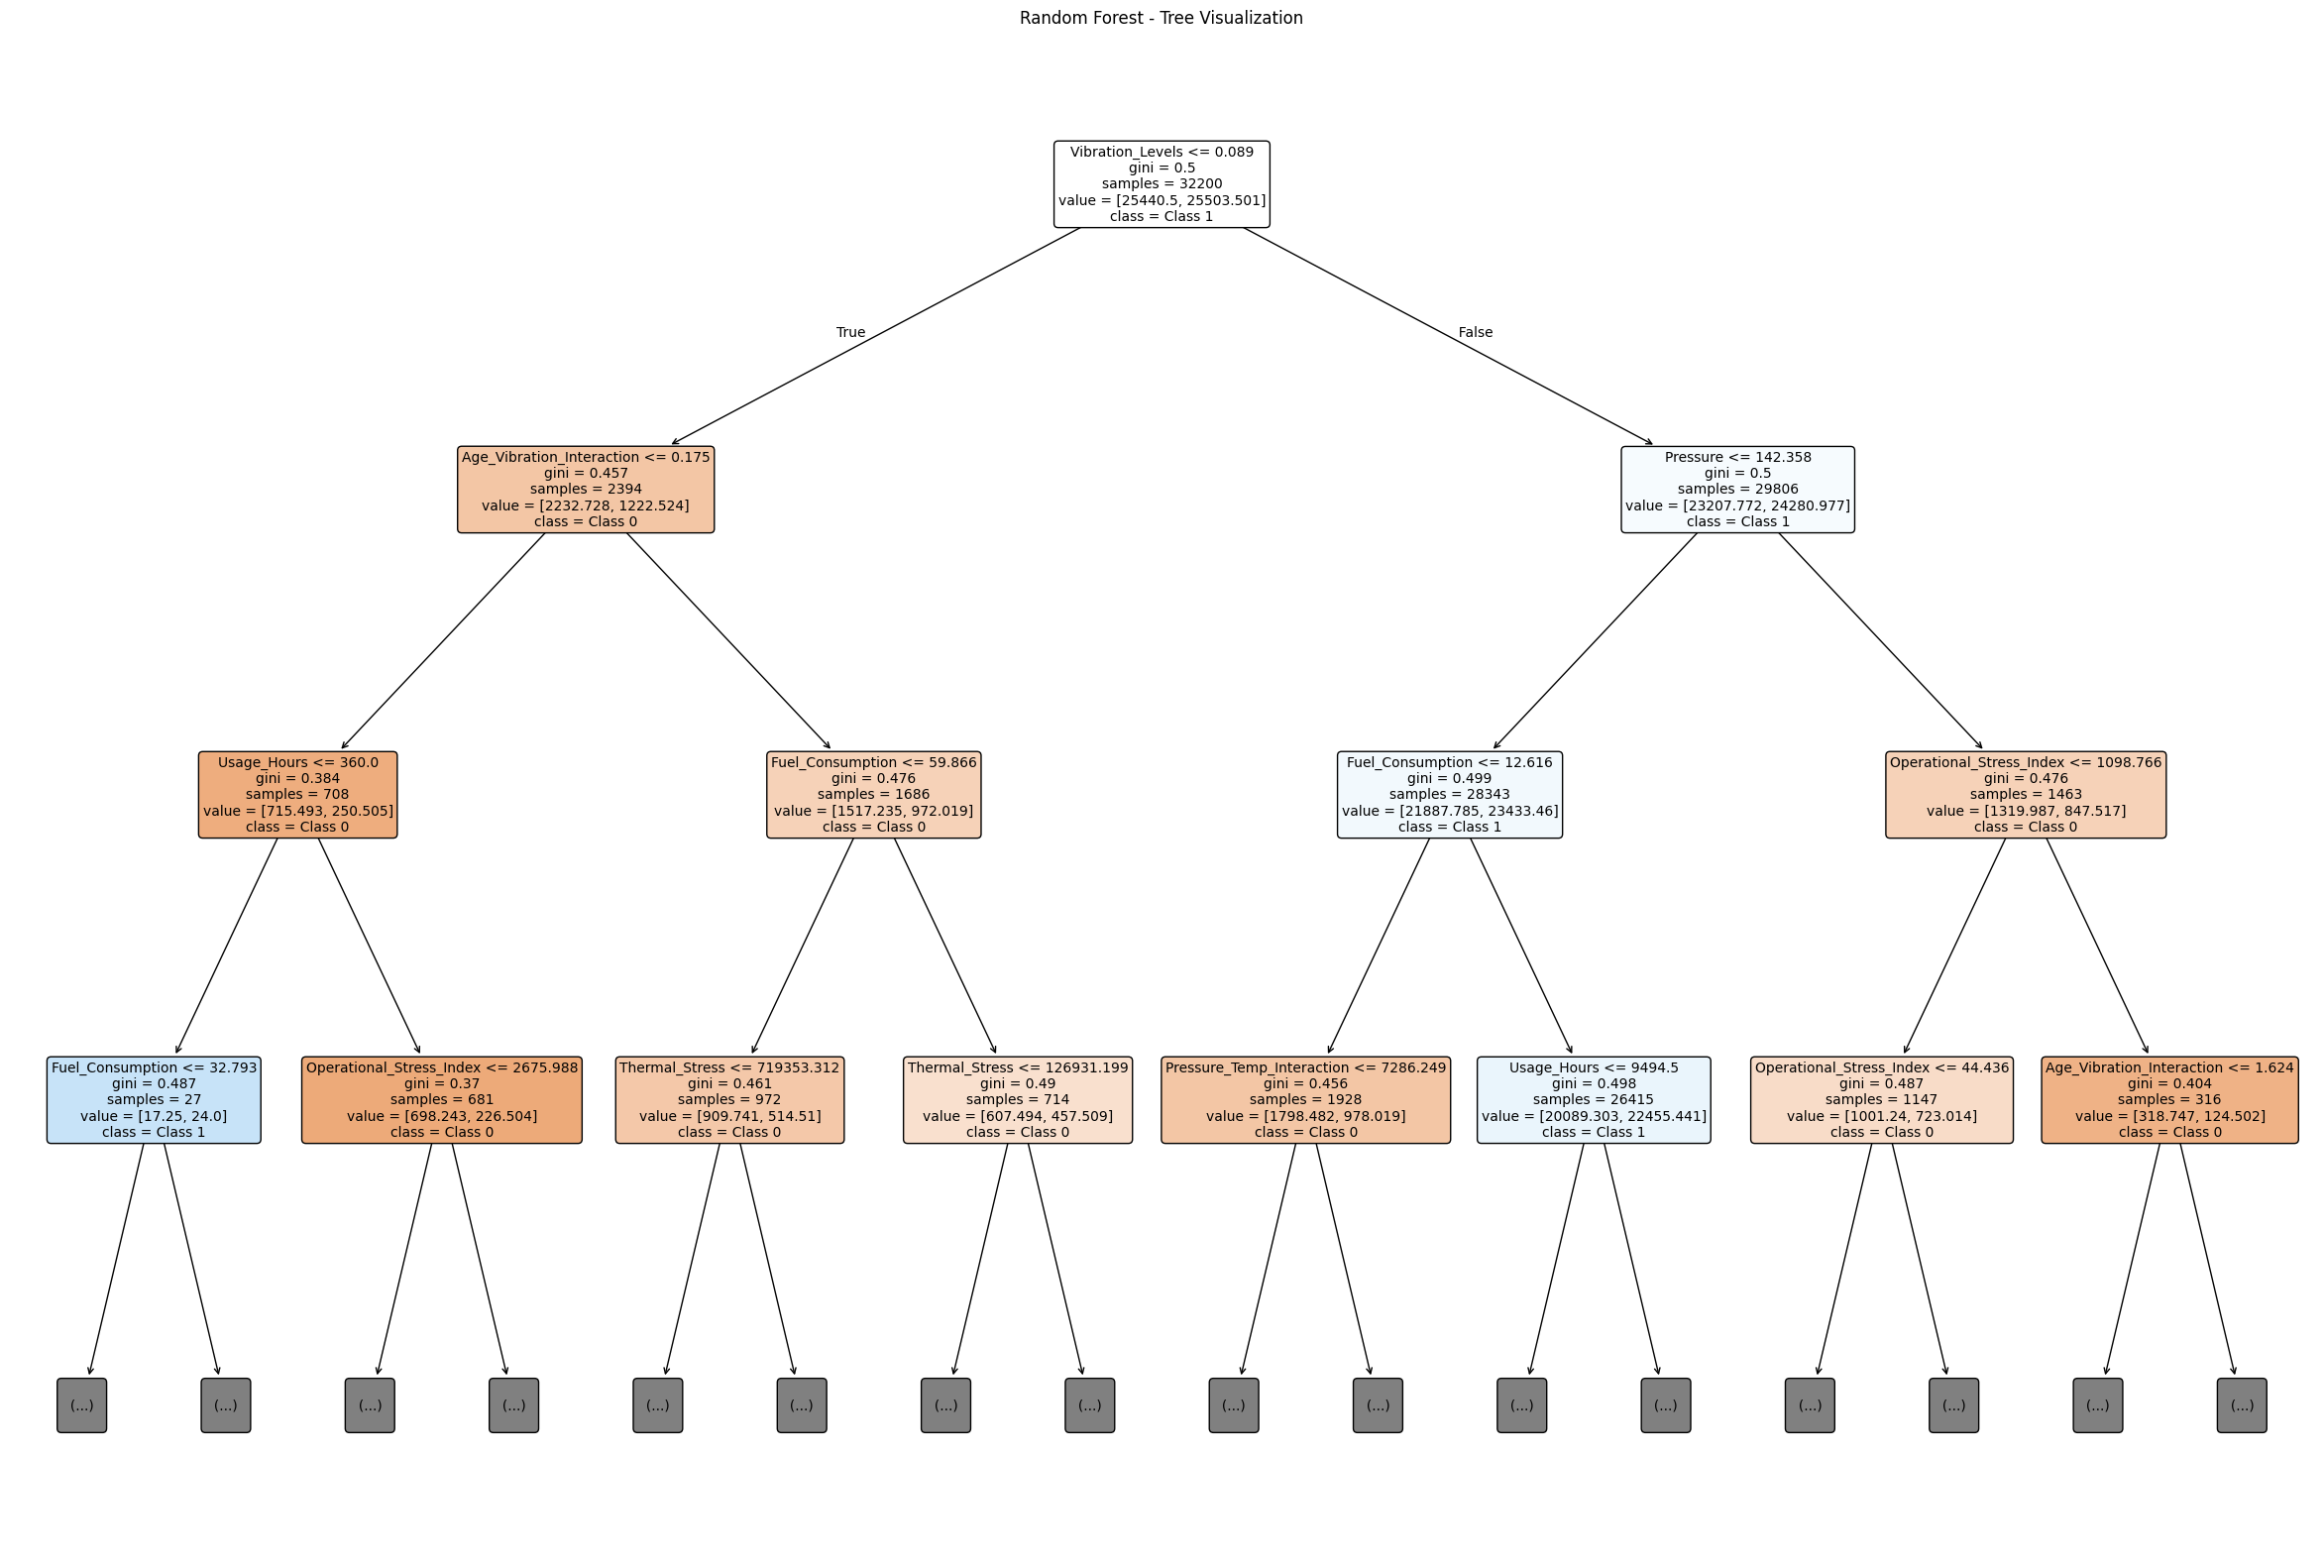

['Failure_event_random_forest_model.joblib']

In [43]:
# STEP 2: Set up a Random Forest with basic pruning options
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# STEP 3: Grid Search for best hyperparameters including pruning-related ones
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 7, None],  # Control tree size (pruning)
    'min_samples_split': [2, 5, 10],  # Prevent overgrowth
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_balanced, y_train_balanced) # using unscalled data for Random Forest

# STEP 4: Get best model and evaluate
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_val)
y_prob = best_rf.predict_proba(X_val)[:, 1]

print("Best Params:", grid_search.best_params_)
print("AUC-ROC:", roc_auc_score(y_val, y_prob))
print(classification_report(y_val, y_pred, digits=4))
mcc = matthews_corrcoef(y_val, y_pred)
print(f"MCC: {mcc:.4f}")

# STEP 5: Plot one of the trees in the forest
plt.figure(figsize=(30, 20))
plot_tree(best_rf.estimators_[0], 
          feature_names=X.columns, 
          class_names=['Class 0', 'Class 1'], 
          filled=True, 
          rounded=True,
          max_depth=3,
          fontsize=10)  # Only show top 3 levels for clarity
plt.title("Random Forest - Tree Visualization")
plt.show()

joblib.dump(best_rf, 'Failure_event_random_forest_model.joblib')

### K-fold on Best model

In [42]:
# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for summary
roc_auc_scores = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_balanced, y_train_balanced), start=1):
    X_train_fold, X_val_fold = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[val_idx]
    
    # Train the best model on this fold
    best_rf.fit(X_train_fold, y_train_fold)
    y_pred = best_rf.predict(X_val_fold)
    y_proba = best_rf.predict_proba(X_val_fold)[:, 1]
    
    # AUC for this fold
    auc = roc_auc_score(y_val_fold, y_proba)
    roc_auc_scores.append(auc)
    
    # Print classification report
    print(f"\nFold {fold} - Classification Report:")
    print(classification_report(y_val_fold, y_pred, digits=4))
    print(f"Fold {fold} - AUC-ROC: {auc:.4f}")
    mcc = matthews_corrcoef(y_val_fold, y_pred)
    print(f"MCC: {mcc:.4f}")

# Print average AUC over all folds
print("\nAverage AUC-ROC across folds:")
print(f"{np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")


Fold 1 - Classification Report:
              precision    recall  f1-score   support

           0     0.7487    0.9405    0.8337      6790
           1     0.7560    0.3688    0.4957      3395

    accuracy                         0.7499     10185
   macro avg     0.7524    0.6546    0.6647     10185
weighted avg     0.7512    0.7499    0.7211     10185

Fold 1 - AUC-ROC: 0.7769
MCC: 0.3951

Fold 2 - Classification Report:
              precision    recall  f1-score   support

           0     0.7461    0.9471    0.8347      6790
           1     0.7706    0.3552    0.4863      3395

    accuracy                         0.7498     10185
   macro avg     0.7583    0.6512    0.6605     10185
weighted avg     0.7542    0.7498    0.7185     10185

Fold 2 - AUC-ROC: 0.7795
MCC: 0.3952

Fold 3 - Classification Report:
              precision    recall  f1-score   support

           0     0.7450    0.9367    0.8299      6790
           1     0.7391    0.3588    0.4830      3395

    accur

# Needs Maintainence

## Reprepping Data

In [44]:
df["needs_maintenance"] = (df["Maintenance_History"] > 0).astype(int)

In [45]:
df.value_counts('needs_maintenance')

needs_maintenance
1    33303
0    16697
Name: count, dtype: int64

In [46]:
df.value_counts('Maintenance_History')

Maintenance_History
2    16714
0    16697
1    16589
Name: count, dtype: int64

In [47]:
df[["Asset_Type","needs_maintenance"]].value_counts()

Asset_Type  needs_maintenance
2           1                    11167
1           1                    11069
0           1                    11067
1           0                     5640
0           0                     5542
2           0                     5515
Name: count, dtype: int64

### Data Pre processing

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from imblearn.over_sampling import SMOTENC
from collections import Counter

# Features and target
X = df.drop(columns=['Maintenance_History','needs_maintenance'])
y = df['needs_maintenance']

# Define categorical and numerical features
cat_features = ['Asset_Type', 'Location']
num_features = [col for col in X.columns if col not in cat_features]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Apply SMOTE to balance the classes in the training data ---
categorical_indices = [X_train.columns.get_loc(col) for col in cat_features]

print("Before SMOTE:", Counter(y_train))

# Apply SMOTENC (for categorical and continuous features)
smote_nc = SMOTENC(
    categorical_features=categorical_indices,
    sampling_strategy=0.7,  # Make minority class 70% the size of the majority class
    random_state=42
)

X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train, y_train)

# Convert back to DataFrame for further processing
X_train_final = pd.DataFrame(X_train_balanced, columns=X_train.columns)
y_train_final = pd.Series(y_train_balanced, name='needs_maintenance')

print("After SMOTE:", Counter(y_train_balanced))

# --- Scale numeric features after SMOTE ---
scaler = StandardScaler()

# Separate numerical columns for scaling
X_train_num = X_train_final[num_features]
X_val_num = X_val[num_features]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled = scaler.transform(X_val_num)

# Convert back to DataFrame
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=num_features).reset_index(drop=True)
X_val_num_scaled_df = pd.DataFrame(X_val_num_scaled, columns=num_features).reset_index(drop=True)

# Prepare final training and validation sets by combining scaled numeric and encoded categorical features
X_train_final = pd.concat([X_train_num_scaled_df, X_train_final[cat_features].reset_index(drop=True)], axis=1)
X_val_final = pd.concat([X_val_num_scaled_df, X_val[cat_features].reset_index(drop=True)], axis=1)

Before SMOTE: Counter({1: 26642, 0: 13358})
After SMOTE: Counter({1: 26642, 0: 18649})


## ANN

In [22]:
# Set up Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store AUC scores
auc_scores = []

manual_weights = {0: 5, 1: 1}

# Start cross-validation loop
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_final, y_train_final), 1):
    print(f"\n--- Fold {fold} ---")
    
    # Split data
    X_train_fold, X_val_fold = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_final.iloc[train_idx], y_train_final.iloc[val_idx]

    # Compute class weights
    classes = np.unique(y_train_fold)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fold)
    class_weight_dict = dict(zip(classes, class_weights))

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

    # Define model
    model = Sequential([
        Dense(12, activation='relu', kernel_initializer = 'he_normal', input_shape=(X_train_final.shape[1],)),
        Dropout(0.3),
        BatchNormalization(),
        
        Dense(12, activation='relu',kernel_initializer = 'he_normal'),
        Dropout(0.3),
        BatchNormalization(),
        
        Dense(10, activation='relu',kernel_initializer = 'he_normal'),
        Dropout(0.3),
        
        Dense(1, kernel_initializer = 'glorot_normal',activation='sigmoid')
    ])

    # Compile
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

    # Fit model
    model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=32,
        class_weight=class_weight_dict,
        verbose=1,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Evaluate
    y_pred_prob = model.predict(X_val_fold).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_val_fold, y_pred, digits=4))

    # AUC score
    auc = roc_auc_score(y_val_fold, y_pred_prob)
    auc_scores.append(auc)
    print(f"AUC-ROC: {auc:.4f}")
    mcc = matthews_corrcoef(y_val_fold, y_pred)
    print(f"MCC: {mcc:.4f}")

# Final average AUC across folds
print("\nAverage AUC-ROC across folds:")
print(f"{np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
torch.save(model, "Needs_Maintainence_ANN.pth")



--- Fold 1 ---
Epoch 1/50
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 38s 26ms/step - AUC: 0.4948 - Precision: 0.3360 - Recall: 0.5292 - accuracy: 0.4887 - loss: 0.7899 - val_AUC: 0.4900 - val_Precision: 0.3167 - val_Recall: 0.3832 - val_accuracy: 0.5188 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 2/50
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - AUC: 0.5097 - Precision: 0.3381 - Recall: 0.4615 - accuracy: 0.5249 - loss: 0.6927 - val_AUC: 0.4987 - val_Precision: 0.3386 - val_Recall: 0.6878 - val_accuracy: 0.4481 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 3/50
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - AUC: 0.5001 - Precision: 0.3348 - Recall: 0.5532 - accuracy: 0.4829 - loss: 0.6941 - val_AUC: 0.4988 - val_Precision: 0.3296 - val_Recall: 0.2881 - val_accuracy: 0.5674 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 4/50
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - AUC: 0.5038 - Precision: 0.3410 - Recall: 0.5472 - accuracy: 0.4887 - loss: 0.6962 - val_AUC: 0.5029 - val_Precision

## FNN with embeddings

In [ ]:
# Settings
FOLDS = 5
RANDOM_STATE = 42
EPOCHS = 200
BATCH_SIZE = 64
cat_cols = ['Asset_Type', 'Location']
num_cols = [col for col in X_train_final.columns if col not in cat_cols]

# Initialize stratified k-fold
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
cv_metrics = defaultdict(list)

# Convert to numpy for indexing
X_all = X_train_final.copy().reset_index(drop=True)
y_all = y_train_final.reset_index(drop=True)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_all, y_all)):
    print(f"\n=== Fold {fold + 1}/{FOLDS} ===")

    # Split the data
    FNN_X_train, FNN_X_val = X_all.iloc[train_idx], X_all.iloc[val_idx]
    FNN_y_train, FNN_y_val = y_all.iloc[train_idx], y_all.iloc[val_idx]

    FNN_X_train_cat = FNN_X_train[cat_cols].reset_index(drop=True)
    FNN_X_val_cat = FNN_X_val[cat_cols].reset_index(drop=True)

    # Numeric features
    FNN_X_train_num = FNN_X_train[num_cols].values
    FNN_X_val_num = FNN_X_val[num_cols].values

    # Define inputs
    input_cats = [Input(shape=(1,), name=f"{col}") for col in cat_cols]
    input_num = Input(shape=(len(num_cols),), name="numeric")

    # Embeddings
    embeddings = []
    for i, col in enumerate(cat_cols):
        vocab_size = int(FNN_X_train_cat[col].nunique()) + 1
        emb_dim = min(50, vocab_size // 2)
        emb = Embedding(input_dim=vocab_size, output_dim=emb_dim, name=f"emb_{col}")(input_cats[i])
        embeddings.append(Flatten()(emb))

    # Model definition
    x = Concatenate()(embeddings + [input_num])
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_cats + [input_num], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]

    # Compute class weights
    classes = np.unique(y_train_fold)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fold)
    class_weight_dict = dict(zip(classes, class_weights))

    # Fit model
    model.fit(
        [FNN_X_train_cat[col].values for col in cat_cols] + [FNN_X_train_num],
        FNN_y_train,
        validation_data=([FNN_X_val_cat[col].values for col in cat_cols] + [FNN_X_val_num], FNN_y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        class_weight = class_weight_dict,
        verbose=1
    )

    # Predict
    y_pred = model.predict([FNN_X_val_cat[col].values for col in cat_cols] + [FNN_X_val_num])
    y_pred_bin = (y_pred >= 0.5).astype(int)

    auc = roc_auc_score(FNN_y_val, y_pred)
    print(f"AUC: {auc:.4f}")
    print(classification_report(FNN_y_val, y_pred_bin, digits=4))
    mcc = matthews_corrcoef(FNN_y_val, y_pred_bin)
    print(f"MCC: {mcc:.4f}")

    cv_metrics['auc'].append(auc)

# Summary
print("\n=== Cross-Validation Summary ===")
for metric, scores in cv_metrics.items():
    print(f"{metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

torch.save(model, 'Needs_Maintainence_fnn_model_with_embeddings.pth')



=== Fold 1/5 ===
Epoch 1/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.5340 - auc_19: 0.5443 - loss: 0.6909 - val_accuracy: 0.5637 - val_auc_19: 0.6159 - val_loss: 0.6750
Epoch 2/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5592 - auc_19: 0.6078 - loss: 0.6766 - val_accuracy: 0.5805 - val_auc_19: 0.6424 - val_loss: 0.6688
Epoch 3/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5785 - auc_19: 0.6244 - loss: 0.6684 - val_accuracy: 0.5619 - val_auc_19: 0.6428 - val_loss: 0.6741
Epoch 4/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5784 - auc_19: 0.6295 - loss: 0.6672 - val_accuracy: 0.5846 - val_auc_19: 0.6479 - val_loss: 0.6652
Epoch 5/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5824 - auc_19: 0.6395 - loss: 0.6654 - val_accuracy: 0.5933 - val_auc_19: 0.6536 - val_loss: 0.6606
Epoch 6/200
637/637 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5844 - auc_19: 0.6393 - loss: 0.6636 - val_accuracy: 0.5988 - val_au

## TAB NET

In [24]:
# Configuration
TARGET_COL = 'Failure_Event'
CATEGORICAL_COLS = ['Asset_Type', 'Location']
RANDOM_STATE = 42
N_SPLITS = 5
EPOCHS = 100
BATCH_SIZE = 64

# Identify categorical feature indices and dimensions
cat_idxs = [X_train_balanced.columns.get_loc(col) for col in CATEGORICAL_COLS]
cat_dims = [int(df[col].nunique()) for col in CATEGORICAL_COLS]
cat_emb_dim = [min(50, (dim + 1) // 2) for dim in cat_dims]

# Cross-validation setup
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

fold = 1
auc_scores = []
# Compute class weights for this fold
classes = np.unique(y_train_balanced)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_balanced)
weights = dict(zip(classes, class_weights))

for train_idx, val_idx in skf.split(X_train_balanced, y_train_balanced):
    print(f"\n==== Fold {fold} ====")
    
    TAB_X_train, TAB_X_val = X_train_balanced.values[train_idx], X_train_balanced.values[val_idx]
    TAB_y_train, TAB_y_val = y_train_balanced.values[train_idx], y_train_balanced.values[val_idx]

    # Initialize and train the model
    clf = TabNetClassifier(
        n_d=32, n_a=32, n_steps=5, gamma=1.5,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=cat_emb_dim,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-2),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        seed=RANDOM_STATE,
        verbose=1
    )

    clf.fit(
        X_train=TAB_X_train, y_train=TAB_y_train,
        eval_set=[(TAB_X_val, TAB_y_val)],
        eval_name=['val'],
        eval_metric=['auc'],
        max_epochs=EPOCHS,
        patience=20,
        batch_size=BATCH_SIZE,
        virtual_batch_size=128,
        weights=weights
    )

    # Evaluation
    y_pred_proba = clf.predict_proba(TAB_X_val)[:, 1]
    y_pred = clf.predict(TAB_X_val)
    auc = roc_auc_score(TAB_y_val, y_pred_proba)
    auc_scores.append(auc)
    
    print(f"Fold {fold} AUC: {auc:.4f}")
    print(classification_report(TAB_y_val, y_pred, digits=4))
    mcc = matthews_corrcoef(TAB_y_val, y_pred)
    print(f"MCC: {mcc:.4f}")
    
    fold += 1

# Final average AUC
print(f"\n==== Cross-Validation Complete ====")
print(f"Mean AUC: {np.mean(auc_scores):.4f} | Std AUC: {np.std(auc_scores):.4f}")
clf.save_model("Needs_Maintainence_tabnet_model")



==== Fold 1 ====
epoch 0  | loss: 0.73069 | val_auc: 0.53914 |  0:00:08s
epoch 1  | loss: 0.68928 | val_auc: 0.57515 |  0:00:15s
epoch 2  | loss: 0.68205 | val_auc: 0.58483 |  0:00:22s
epoch 3  | loss: 0.68206 | val_auc: 0.57548 |  0:00:29s
epoch 4  | loss: 0.68245 | val_auc: 0.57734 |  0:00:36s
epoch 5  | loss: 0.67917 | val_auc: 0.5985  |  0:00:45s
epoch 6  | loss: 0.67665 | val_auc: 0.60336 |  0:00:52s
epoch 7  | loss: 0.67725 | val_auc: 0.59414 |  0:01:00s
epoch 8  | loss: 0.67889 | val_auc: 0.61598 |  0:01:08s
epoch 9  | loss: 0.67492 | val_auc: 0.62279 |  0:01:16s
epoch 10 | loss: 0.67506 | val_auc: 0.61996 |  0:01:24s
epoch 11 | loss: 0.67314 | val_auc: 0.62216 |  0:01:32s
epoch 12 | loss: 0.67187 | val_auc: 0.6229  |  0:01:40s
epoch 13 | loss: 0.67292 | val_auc: 0.62075 |  0:01:49s
epoch 14 | loss: 0.67032 | val_auc: 0.62916 |  0:01:57s
epoch 15 | loss: 0.66964 | val_auc: 0.6254  |  0:02:05s
epoch 16 | loss: 0.66944 | val_auc: 0.63742 |  0:02:13s
epoch 17 | loss: 0.66716 | val

'Needs_Maintainence_tabnet_model.zip'

## XG Boost with parameter slection

In [45]:
scale_pos_weight = len(y_train_balanced) / (2 * np.sum(y_train_balanced))

params = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, scale_pos_weight, scale_pos_weight * 1.5]
}

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=params, 
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

search.fit(X_train_balanced, y_train_balanced)
best_model = search.best_estimator_

# Predict on validation set
y_pred_prob = best_model.predict_proba(X_val)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

# Evaluate
print("Classification Report:")
print(classification_report(y_val, y_pred, digits=4))
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_prob):.4f}")
print(f"Precision: {precision_score(y_val, y_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_pred):.4f}")
mcc = matthews_corrcoef(y_val, y_pred)
print(f"MCC: {mcc:.4f}")

joblib.dump(model, 'Maintainence_Need_xgb_model.pkl')


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=100, scale_pos_weight=1.2749887395841153, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, scale_pos_weight=0.8499924930560768, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=100, scale_pos_weight=1.2749887395841153, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=100, scale_pos_weight=1.2749887395841153, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, scale_pos_weight=0.8499924930560768, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, scale_pos_weight=0.8499924930560768, subsample=0.8; total time=   0.9s
[CV] END colsample_by

['Maintainence_Need_xgb_model.pkl']

### K-fold cross validation on best model

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for summary
roc_auc_scores = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_balanced, y_train_balanced), start=1):
    X_train_fold, X_val_fold = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[val_idx]
    
    # Train the best model on this fold
    best_model.fit(X_train_fold, y_train_fold)
    y_pred = best_model.predict(X_val_fold)
    y_proba = best_model.predict_proba(X_val_fold)[:, 1]
    
    # AUC for this fold
    auc = roc_auc_score(y_val_fold, y_proba)
    roc_auc_scores.append(auc)
    
    # Print classification report
    print(f"\nFold {fold} - Classification Report:")
    print(classification_report(y_val_fold, y_pred, digits=4))
    print(f"Fold {fold} - AUC-ROC: {auc:.4f}")
    mcc = matthews_corrcoef(y_val_fold, y_pred)
    print(f"MCC: {mcc:.4f}")

# Print average AUC over all folds
print("\nAverage AUC-ROC across folds:")
print(f"{np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")



Fold 1 - Classification Report:
              precision    recall  f1-score   support

           0     0.5548    0.3879    0.4566      3730
           1     0.6461    0.7821    0.7076      5329

    accuracy                         0.6198      9059
   macro avg     0.6005    0.5850    0.5821      9059
weighted avg     0.6085    0.6198    0.6043      9059

Fold 1 - AUC-ROC: 0.6140
MCC: 0.1849

Fold 2 - Classification Report:
              precision    recall  f1-score   support

           0     0.5311    0.3800    0.4430      3729
           1     0.6382    0.7652    0.6960      5329

    accuracy                         0.6066      9058
   macro avg     0.5846    0.5726    0.5695      9058
weighted avg     0.5941    0.6066    0.5918      9058

Fold 2 - AUC-ROC: 0.6022
MCC: 0.1568

Fold 3 - Classification Report:
              precision    recall  f1-score   support

           0     0.5437    0.3866    0.4519      3730
           1     0.6428    0.7729    0.7019      5328

    accur

## Random Forest Model

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
AUC-ROC: 0.5045436419698883
              precision    recall  f1-score   support

           0     0.3440    0.1518    0.2107      3339
           1     0.6678    0.8548    0.7499      6661

    accuracy                         0.6201     10000
   macro avg     0.5059    0.5033    0.4803     10000
weighted avg     0.5597    0.6201    0.5698     10000

MCC: 0.0089


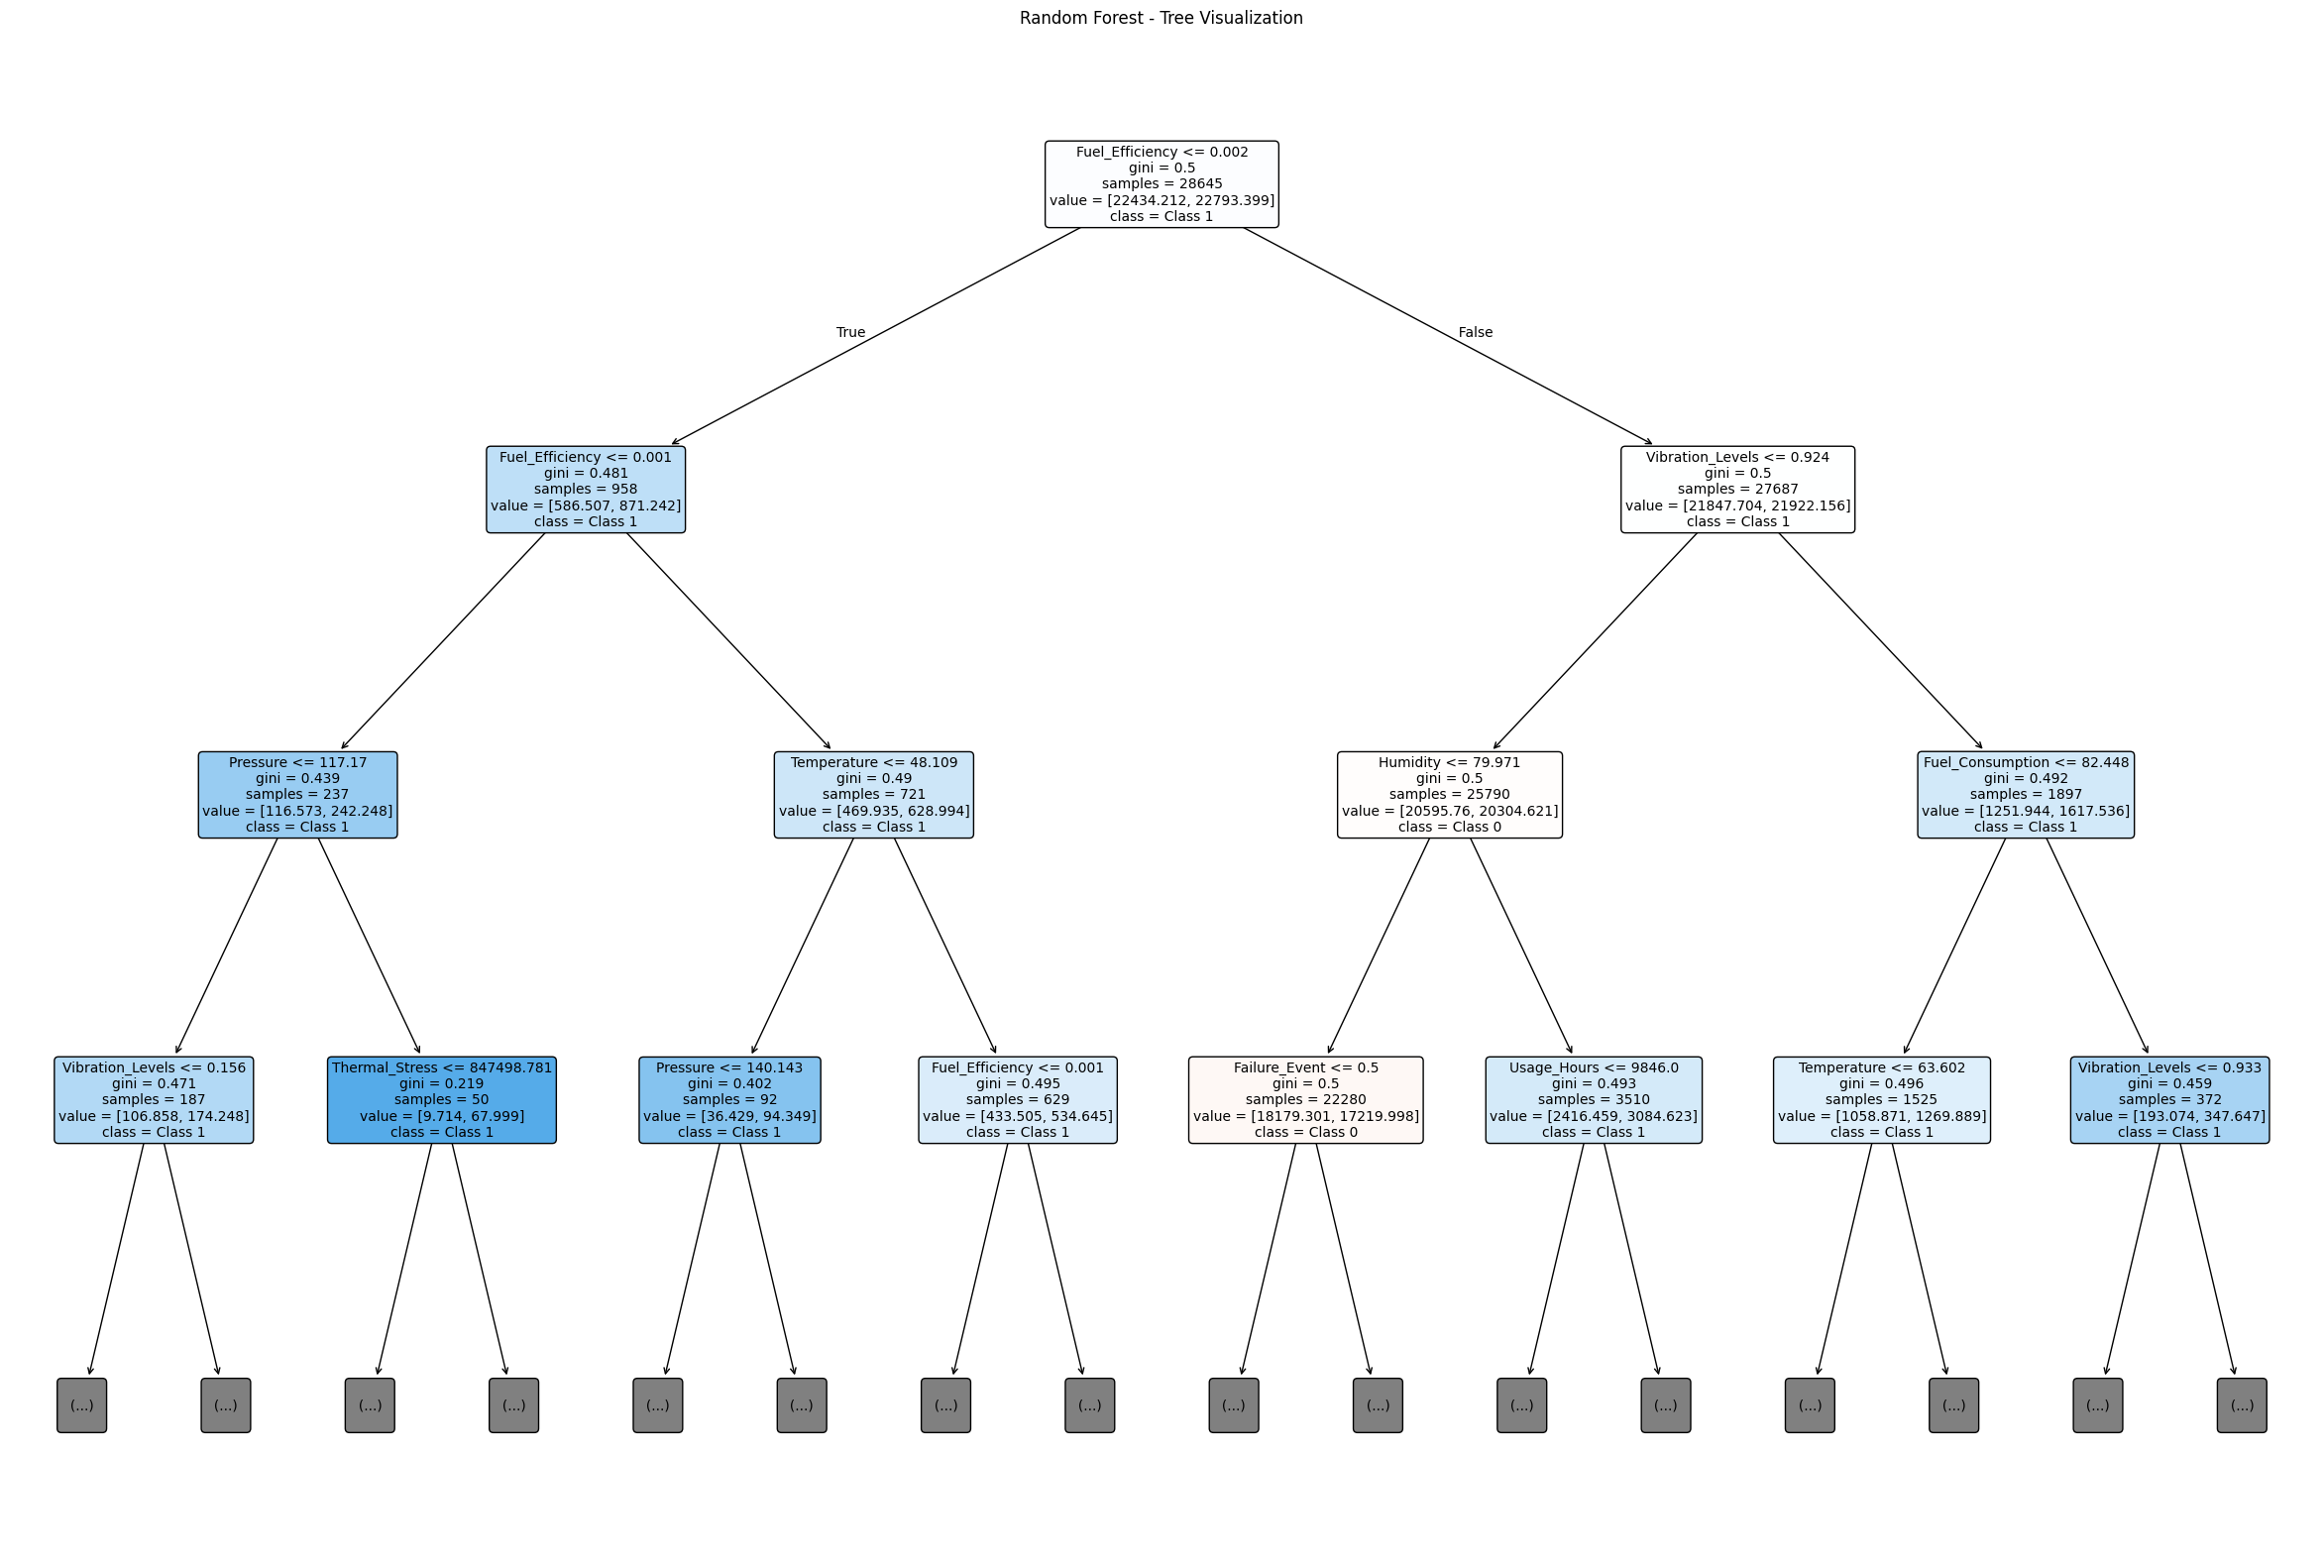

['maintainence_needs_random_forest_model.joblib']

In [49]:
# STEP 2: Set up a Random Forest with basic pruning options
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# STEP 3: Grid Search for best hyperparameters including pruning-related ones
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 7, None],  # Control tree size (pruning)
    'min_samples_split': [2, 5, 10],  # Prevent overgrowth
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_balanced, y_train_balanced) # using unscalled data for Random Forest

# STEP 4: Get best model and evaluate
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_val)
y_prob = best_rf.predict_proba(X_val)[:, 1]

print("Best Params:", grid_search.best_params_)
print("AUC-ROC:", roc_auc_score(y_val, y_prob))
print(classification_report(y_val, y_pred, digits=4))
mcc = matthews_corrcoef(y_val, y_pred)
print(f"MCC: {mcc:.4f}")

# STEP 5: Plot one of the trees in the forest
plt.figure(figsize=(30, 20))
plot_tree(best_rf.estimators_[0], 
          feature_names=X.columns, 
          class_names=['Class 0', 'Class 1'], 
          filled=True, 
          rounded=True,
          max_depth=3,
          fontsize=10)  # Only show top 3 levels for clarity
plt.title("Random Forest - Tree Visualization")
plt.show()

joblib.dump(best_rf, 'maintainence_needs_random_forest_model.joblib')

### K-fold on best model

In [48]:
# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for summary
roc_auc_scores = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_balanced, y_train_balanced), start=1):
    X_train_fold, X_val_fold = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[val_idx]
    
    # Train the best model on this fold
    best_rf.fit(X_train_fold, y_train_fold)
    y_pred = best_rf.predict(X_val_fold)
    y_proba = best_rf.predict_proba(X_val_fold)[:, 1]
    
    # AUC for this fold
    auc = roc_auc_score(y_val_fold, y_proba)
    roc_auc_scores.append(auc)
    
    # Print classification report
    print(f"\nFold {fold} - Classification Report:")
    print(classification_report(y_val_fold, y_pred, digits=4))
    print(f"Fold {fold} - AUC-ROC: {auc:.4f}")
    mcc = matthews_corrcoef(y_val_fold, y_pred)
    print(f"MCC: {mcc:.4f}")

# Print average AUC over all folds
print("\nAverage AUC-ROC across folds:")
print(f"{np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")




Fold 1 - Classification Report:
              precision    recall  f1-score   support

           0     0.5921    0.3051    0.4027      3730
           1     0.6368    0.8529    0.7292      5329

    accuracy                         0.6273      9059
   macro avg     0.6145    0.5790    0.5659      9059
weighted avg     0.6184    0.6273    0.5948      9059

Fold 1 - AUC-ROC: 0.6146
MCC: 0.1902

Fold 2 - Classification Report:
              precision    recall  f1-score   support

           0     0.5830    0.3138    0.4079      3729
           1     0.6371    0.8429    0.7257      5329

    accuracy                         0.6251      9058
   macro avg     0.6100    0.5783    0.5668      9058
weighted avg     0.6148    0.6251    0.5949      9058

Fold 2 - AUC-ROC: 0.6106
MCC: 0.1857

Fold 3 - Classification Report:
              precision    recall  f1-score   support

           0     0.5851    0.2968    0.3938      3730
           1     0.6340    0.8527    0.7272      5328

    accur